In [6]:
# !pip install openpyxl

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, median_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [111]:
df = pd.read_excel("../data/Online Retail.xlsx", sheet_name="Online Retail")
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
455173,575607,23263,SET OF 3 WOODEN HEART DECORATIONS,12,2011-11-10 12:37:00,2.46,14096.0,United Kingdom
121517,546769,22784,LANTERN CREAM GAZEBO,12,2011-03-16 14:57:00,4.25,17504.0,United Kingdom
204268,554648,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-05-25 12:44:00,8.50,12562.0,France
150846,549524,85093,CANDY SPOT EGG WARMER HARE,2,2011-04-08 15:42:00,0.83,NaN,United Kingdom
96861,544591,22927,GREEN GIANT GARDEN THERMOMETER,2,2011-02-21 15:20:00,5.95,13044.0,United Kingdom


In [112]:
print("df.shape: ", df.shape)

df.shape:  (541909, 8)


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [114]:
df = df[df["Quantity"] > 0]

In [115]:
print("df.shape: ", df.shape)

df.shape:  (531285, 8)


In [116]:
#Dropping NaN of thẻ CustomerID
df = df[pd.notnull(df["CustomerID"])]

In [117]:
print("df.shape: ", df.shape)

df.shape:  (397924, 8)


In [118]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 ~ 2011-12-09 12:50:00


In [119]:
# Số giao dịch tính từ 01/12/2011 => sau
df.loc[df["InvoiceDate"] >= "2011-12-01"].shape

(17304, 8)

In [120]:
# Số giao dịch tính từ 01/12/2011 => trước
df.loc[df["InvoiceDate"] < "2011-12-01"].shape

(380620, 8)

In [121]:
#Tạo thêm cột sale = quantity * UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
153286,549735,21935,SUKI SHOULDER BAG,20,2011-04-12 08:42:00,1.65,13824.0,United Kingdom,33.00
99142,544701,22967,SET 3 SONG BIRD PAPER EGGS ASSORTED,48,2011-02-23 10:27:00,2.55,17428.0,United Kingdom,122.40
276227,561036,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,4,2011-07-24 11:54:00,1.25,13137.0,United Kingdom,5.00
338842,566566,21791,VINTAGE HEADS AND TAILS CARD GAME,1,2011-09-13 12:32:00,2.46,14096.0,United Kingdom,2.46
119834,546625,22621,TRADITIONAL KNITTING NANCY,1,2011-03-15 11:45:00,1.45,17542.0,United Kingdom,1.45


In [122]:
#Nhóm dữ liệu theo CustomerID, InvoiceNo
orders_df = df.groupby(["CustomerID", "InvoiceNo"]).agg({
    "Sales": sum,
    "InvoiceDate": max
}).reset_index()
orders_df.sample(5)

,CustomerID,InvoiceNo,Sales,InvoiceDate
15826,17442.0,565844,331.24,2011-09-07 12:19:00
5394,14040.0,563208,39.84,2011-08-14 12:12:00
12828,16422.0,565139,550.98,2011-09-01 12:50:00
11119,15826.0,571248,55.85,2011-10-14 16:05:00
4357,13694.0,564322,2736.99,2011-08-24 13:23:00


In [123]:
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [124]:
summary_df = orders_df.groupby("CustomerID").agg({
    "Sales": [min, max, groupby_mean, groupby_count],
    "InvoiceDate": [min, max, purchase_duration, avg_frequency]
}).reset_index()
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df.sample(5)

,customerid_,sales_min,sales_max,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
3844,17611.0,114.88,497.48,265.614667,15,2010-12-13 13:52:00,2011-12-02 13:29:00,353,23.533333
2771,16123.0,307.78,307.78,307.780000,1,2011-10-19 09:18:00,2011-10-19 09:18:00,0,0.000000
4028,17863.0,342.02,1032.70,526.666667,6,2010-12-05 13:21:00,2011-10-11 13:45:00,310,51.666667
2274,15443.0,247.09,687.86,462.415714,7,2011-01-23 13:25:00,2011-12-08 10:40:00,318,45.428571
1931,14988.0,334.54,334.54,334.540000,1,2011-05-12 12:05:00,2011-05-12 12:05:00,0,0.000000


In [125]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]

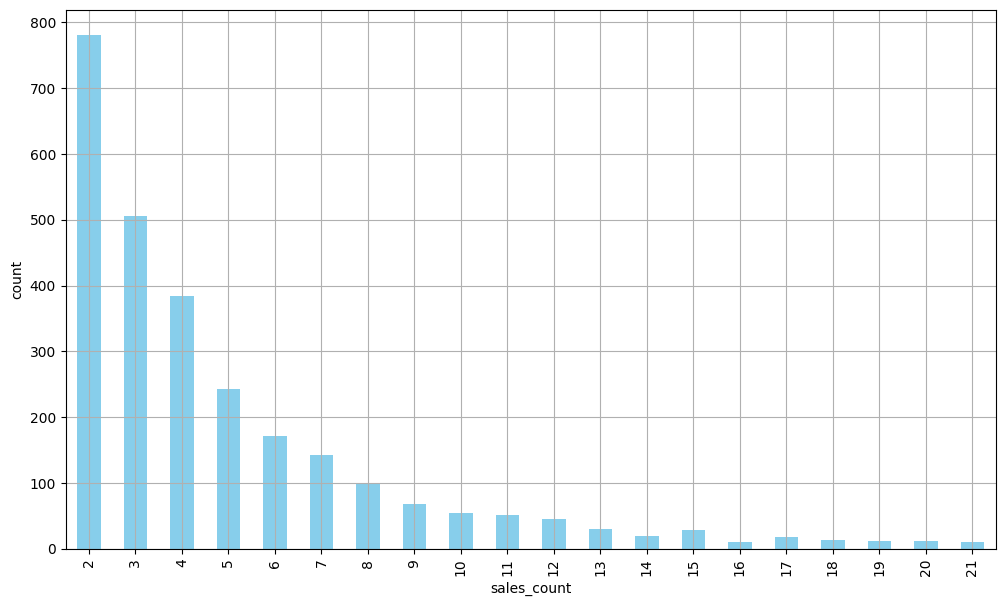

In [126]:
ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar',
    color='skyblue',
    figsize=(12,7),
    grid=True
)
ax.set_ylabel('count')
plt.show()

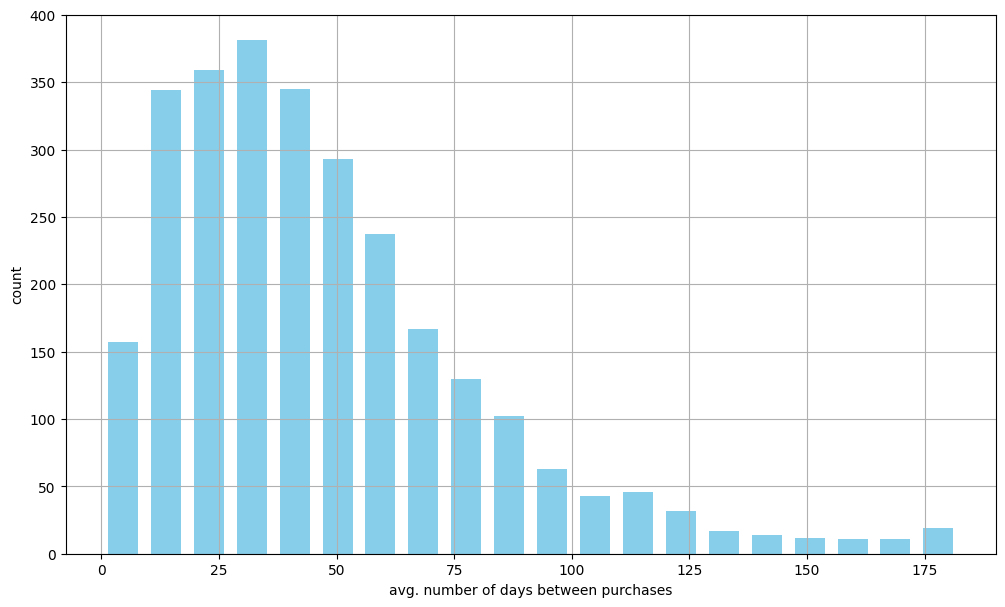

In [127]:
ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)
ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')
plt.show()

In [128]:
clv_freq = '3M'

In [129]:
data_df = orders_df.groupby([
    'CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})
data_df.sample(5)

Sales              
                           sum     avg count
CustomerID InvoiceDate                      
16569.0    2011-12-31   124.20  124.20     1
17379.0    2011-12-31   404.66  404.66     1
13838.0    2011-12-31   212.14  212.14     1
13068.0    2011-03-31   165.00  165.00     1
17759.0    2011-12-31   667.84  667.84     1

In [130]:
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]

In [131]:
data_df = data_df.reset_index()

In [132]:
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1
5,12347.0,2011-12-31,1519.14,759.570,2
6,12348.0,2010-12-31,892.80,892.800,1
7,12348.0,2011-03-31,227.44,227.440,1
8,12348.0,2011-06-30,367.00,367.000,1
9,12348.0,2011-09-30,310.00,310.000,1


In [133]:
date_month_map = {
    str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [134]:
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df.sample(5)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
7350,16987.0,2011-12-31,995.60,248.90,4,M_1
741,12755.0,2010-12-31,3794.40,3794.40,1,M_5
6832,16672.0,2011-09-30,2325.80,465.16,5,M_2
7772,17263.0,2011-06-30,63.44,63.44,1,M_3
8655,17802.0,2011-09-30,652.62,652.62,1,M_2


In [135]:
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'],
    values=['sales_sum', 'sales_avg', 'sales_count'],
    columns='M',
    index='CustomerID'
)
features_df.columns = ['_'.join(col) for col in features_df.columns]
features_df = features_df.fillna(0)
features_df.sample(5)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
13984.0,102.100,432.480000,129.950,154.80,1.0,1.0,1.0,1.0,102.10,432.48,129.95,154.80
13717.0,201.770,228.085000,298.050,0.00,1.0,2.0,1.0,0.0,201.77,456.17,298.05,0.00
15498.0,414.568,383.905556,735.768,488.36,5.0,9.0,5.0,2.0,2072.84,3455.15,3678.84,976.72
13174.0,0.000,0.000000,692.300,1415.97,0.0,0.0,1.0,1.0,0.00,0.00,692.30,1415.97
18129.0,0.000,112.550000,0.000,0.00,0.0,1.0,0.0,0.0,0.00,112.55,0.00,0.00


In [136]:
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

In [137]:
response_df.columns = ['CustomerID', 'CLV_'+ clv_freq]
response_df.sample(5)

,CustomerID,CLV_3M
187,12451.0,3727.70
924,12890.0,380.47
5921,16066.0,1205.49
6785,16648.0,290.66
8683,17827.0,411.65


In [138]:
sample_set_df = features_df.merge(
    response_df,
    left_index=True,
    right_on='CustomerID',
    how='left'
)
sample_set_df = sample_set_df.fillna(0)
sample_set_df.sample(5)

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,306.190000,311.13,336.22,304.95,1.0,2.0,2.0,1.0,306.19,622.26,672.44,304.95,14210.0,0.00
4812.0,336.296667,329.28,254.19,182.77,3.0,3.0,1.0,2.0,1008.89,987.84,254.19,365.54,15356.0,150.04
395.0,0.000000,0.00,0.00,195.89,0.0,0.0,0.0,1.0,0.00,0.00,0.00,195.89,12577.0,461.91
8224.0,288.360000,0.00,0.00,0.00,1.0,0.0,0.0,0.0,288.36,0.00,0.00,0.00,17557.0,253.10
7195.0,0.000000,102.98,0.00,0.00,0.0,1.0,0.0,0.0,0.00,102.98,0.00,0.00,16892.0,422.56


In [139]:
sample_set_df['CLV_'+clv_freq].describe()

count      3616.000000
mean        639.663504
std        3918.788709
min           0.000000
25%           0.000000
50%          69.055000
75%         521.212500
max      168469.600000
Name: CLV_3M, dtype: float64

In [140]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_set_df[all_features],
    sample_set_df[target_var],
    test_size=0.3,
    random_state=42
)

In [176]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [177]:
print("Intercept: %.2f" %model.intercept_)

Intercept: 226.11


In [178]:
coef = pd.DataFrame(list(zip(all_features, model.coef_)))
coef.columns = ['feature', 'coef']
coef

,feature,coef
0,sales_avg_M_2,-0.658807
1,sales_avg_M_3,-0.214716
2,sales_avg_M_4,0.250827
3,sales_avg_M_5,-0.525281
4,sales_count_M_2,-57.083158
5,sales_count_M_3,118.635481
6,sales_count_M_4,-93.650572
7,sales_count_M_5,-15.220785
8,sales_sum_M_2,0.875087
9,sales_sum_M_3,0.009679


In [179]:
print('In-Sample R-Squared: %0.4f' % r2_score(y_true=y_train, y_pred=model.predict(X_train)))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_true=y_test, y_pred=model.predict(X_test)))

In-Sample R-Squared: 0.2819
Out-of-Sample R-Squared: 0.2544


In [180]:
print('In-Sample MSE: %0.4f' % median_absolute_error(y_true=y_train, y_pred=model.predict(X_train)))
print('Out-of-Sample MSE: %0.4f' % median_absolute_error(y_true=y_test, y_pred=model.predict(X_test)))

In-Sample MSE: 277.0809
Out-of-Sample MSE: 267.6646


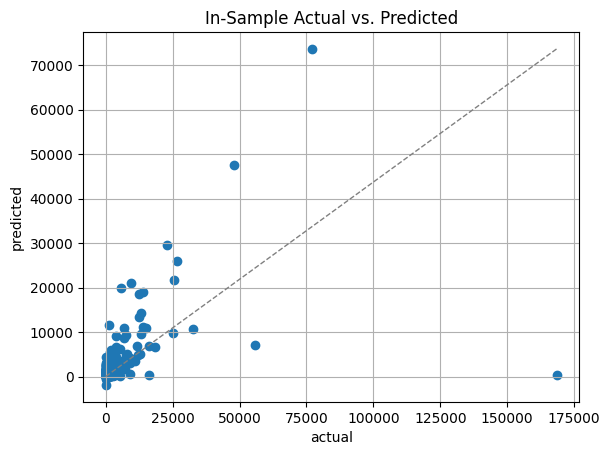

In [174]:
plt.scatter(y_train, model.predict(X_train))
plt.plot([0, max(y_train)], [0, max(model.predict(X_train))],
    color='gray',
    lw=1, linestyle='--')
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()
plt.show()